In [1]:
import spot
spot.setup()

This notebook presents functions that can be used to solve the Reactive Synthesis problem using games.
If you are not familiar with how Spot represent games, please read the `games` notebook first.

In Reactive Synthesis, the goal is to build an electronic circuit that reacts to some input signals by producing some output signals, under some LTL constraints that tie both input and output.  Of course the input signals are not controlable, so only job is to decide what output signal to produce.

# Reactive synthesis in three steps

A strategy/control circuit can be derived more conveniently from an LTL/PSL specification.
The process is decomposed in to three steps:
- Creating the game
- Solving the game
- Obtaining the strategy

Each of these steps is parametrized by a structure called `synthesis_info`.  This structure stores some additional data needed to pass fine-tuning options or to store statistics.

The `ltl_to_game` function takes the LTL specification, and the list of controlable atomic propositions (or output signals).  It returns a two-player game, where player 0 plays the input variables (and wants to invalidate the acceptance condition), and player 1 plays the output variables (and wants to satisfy the output condition).  The conversion from LTL to parity automata can use one of many algorithms, and can be specified in the `synthesis_info` structure (this works like the `--algo=` option of `ltlsynt`).

game has 29 states and 55 edges
output propositions are: o0


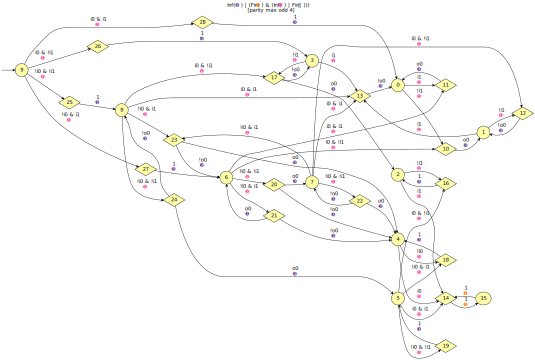

In [2]:
si = spot.synthesis_info()
si.s = spot.synthesis_info.algo_LAR # Use LAR algorithm

game = spot.ltl_to_game("G((F(i0) && F(i1))->(G(i1<->(X(o0)))))", ["o0"], si)
print("game has", game.num_states(), "states and", game.num_edges(), "edges")
print("output propositions are:", ", ".join(spot.get_synthesis_output_aps(game)))
display(game)

Solving the game, is done with `solve_game()` as with any game.  There is also a version that takes a `synthesis_info` as second argument in case the time it takes has to be recorded.  Here passing `si` or not makes no difference.

Found a solution: True


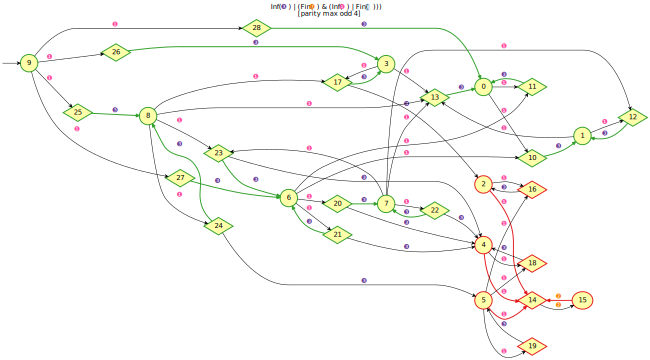

In [3]:
print("Found a solution:", spot.solve_game(game, si))
spot.highlight_strategy(game)
game.show('.g')

Once a strategy has been found, it can be extracted as an automaton and simplified using 6 different levels (the default is 2).  The output should be interpreted as a mealy automaton, where transition are labeled by combination of input assignments and associated output assignments.

simplification lvl 0


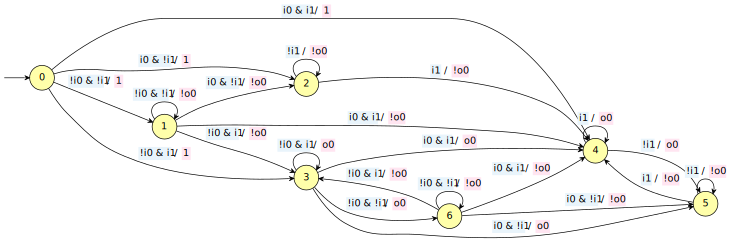

simplification lvl 1


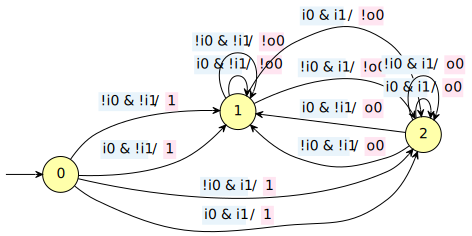

simplification lvl 2


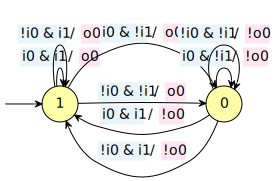

simplification lvl 3


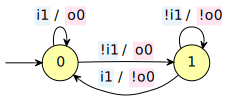

simplification lvl 4


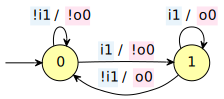

simplification lvl 5


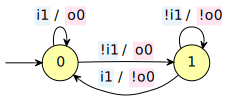

In [4]:
# We have different levels of simplification:
# 0 : No simplification
# 1 : bisimulation-based reduction
# 2 : bisimulation-based reduction with output output assignement
# 3 : SAT-based exact minimization
# 4 : First 1 then 3 (exact)
# 5 : First 2 then 3 (not exact)
for i in range(6):
    print("simplification lvl", i)
    si.minimize_lvl = i
    strat = spot.create_strategy(game, si)
    display(strat.show())

Alternatively, the `apply_strategy` is a more low-level function that can be used to restrict the automaton to the part where player 1 is winning, without simplifying it.  It's second argument controls whether pairs of transitions corresponding to each player should be fused back into a single transition.  The third argument controls whether the game's acceptance condition should be copied.

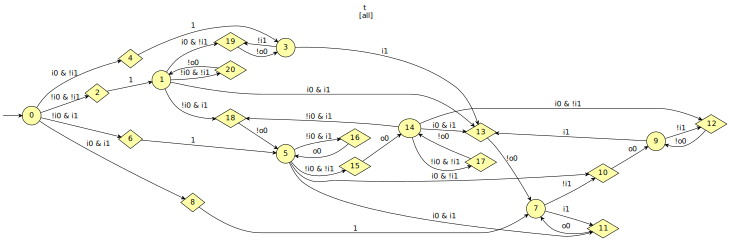

In [5]:
spot.apply_strategy(game, False, False)

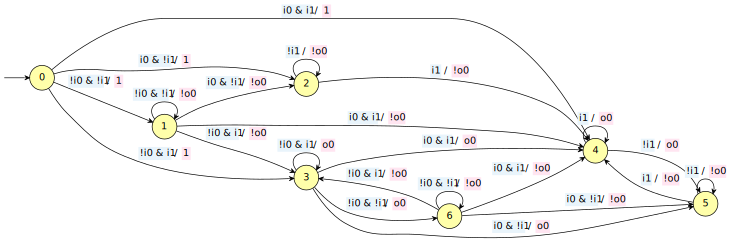

In [6]:
spot.apply_strategy(game, True, False)

# Converting the strategy to AIGER

A strategy can be converted to a circuit in the [AIGER format](http://fmv.jku.at/aiger/FORMAT.aiger) using `strategy_to_aig()`.  This takes a second argument specifying what type of encoding to use (exactly like `ltlsynt`'s `--aiger=...` option).  

In this case, the circuit is quite simple: `o0` should be the negation of previous value of `i1`.  This is done by storing the value of `i1` in a latch.  And the value if `i0` can be ignored.

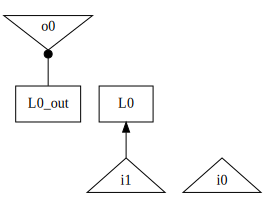

aag 3 2 1 1 0
2
4
6 3
7
i0 i1
i1 i0
o0 o0


In [7]:
aig = spot.strategy_to_aig(strat, "isop")
display(aig)
print(aig.to_str())

# Adding more inputs and outputs by force

It can happen that propositions declared as output are ommited in the aig circuit (either because they are not part of the specification, or because they do not appear in the winning strategy).  In that case those 
values can take arbitrary values.

For instance so following constraint mention `o1` and `i1`, but those atomic proposition are actually unconstrained (`F(... U x)` can be simplified to `Fx`).  Without any indication, the circuit built will ignore those variables:

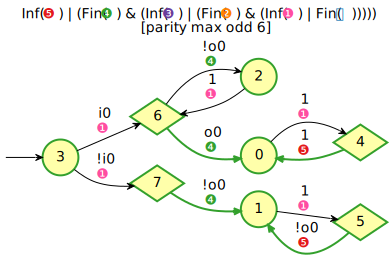

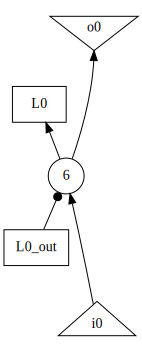

In [8]:
game = spot.ltl_to_game("i0 <-> F((Go1 -> Fi1) U o0)", ["o0", "o1"])
spot.solve_game(game)
spot.highlight_strategy(game)
display(game)
strat = spot.create_strategy(game)
aig = spot.strategy_to_aig(strat, "isop")
display(aig)

To force the presence of extra variables in the circuit, they can be passed to `strategy_to_aig()`.

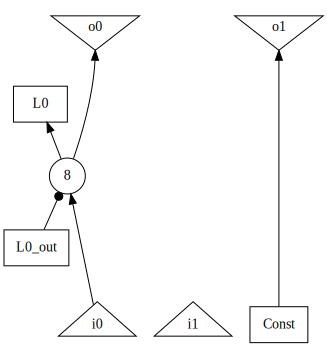

In [9]:
display(spot.strategy_to_aig(strat, "isop", ["i0", "i1"], ["o0", "o1"]))

# Reading an AIGER-file

Note that we do not support the full [AIGER syntax](http://fmv.jku.at/aiger/FORMAT.aiger).  Our restrictions corresponds to the conventions used in the type of AIGER file we output:
- Input variables start at index 2 and are consecutively numbered.
- Latch variables start at index (1 + #inputs) * 2 and are consecutively numbered.
- If some inputs or outputs are named in comments, all of them have to be named.
- Gate number $n$ can only connect to latches, inputs, or previously defined gates ($<n$).

In [10]:
aag_txt = """aag 5 2 0 2 3
2
4
10
6
6 2 4
8 3 5
10 7 9
i0 a
i1 b
o0 c
o1 d"""

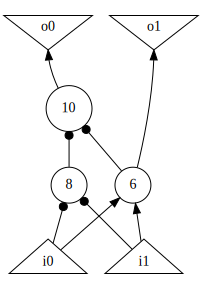

In [11]:
this_aig = spot.aiger_circuit(aag_txt)
display(this_aig)

In [12]:
print(this_aig.to_str())

aag 5 2 0 2 3
2
4
10
6
6 2 4
8 3 5
10 7 9
i0 i0
i1 i1
o0 o0
o1 o1


In [13]:
print(this_aig.gates())

((2, 4), (3, 5), (7, 9))


An aiger circuit can be transformed into a monitor.  This can help for instance to verify that it does not intersect the negation of the specification.

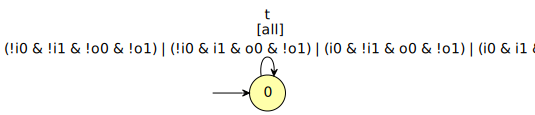

In [14]:
this_aig.as_automaton()